In [8]:
import numpy as np
import os
from skimage.draw import line
from math import atan2, degrees

# CONFIG
BASE_GRID_PATH = "Processed_Area"
BASE_VIS_PATH = "Processed_Area"
MAX_RANGE = 25  # cells (5m)
CONE_ANGLE = 90  # degrees
DIRECTIONS = [0, 90, 180, 270]  # Cardinal directions
AREAS = [f"Area_{i}" for i in range(1, 7)]


# Ensure output folders exist
for area in AREAS:
    os.makedirs(os.path.join(BASE_VIS_PATH, f"{area}_conical_visibility"), exist_ok=True)


In [9]:
# Helpers
def angle_between(p1, p2):
    dy, dx = p2[0] - p1[0], p2[1] - p1[1]
    return (degrees(atan2(dy, dx)) + 360) % 360

def within_cone(center, target, direction_deg, cone_angle):
    angle = angle_between(center, target)
    diff = (angle - direction_deg + 360) % 360
    return diff <= cone_angle/2 or diff >= 360 - cone_angle/2

def is_visible(grid, src, dst):
    rr, cc = line(src[0], src[1], dst[0], dst[1])
    for r, c in zip(rr, cc):
        if r < 0 or c < 0 or r >= grid.shape[0] or c >= grid.shape[1]:
            return False
        if grid[r, c] == 1:
            return False
    return True

In [10]:
# Batch process all areas
for area in AREAS:
    grid_folder = os.path.join(BASE_GRID_PATH, f"{area}_grid")
    out_folder = os.path.join(BASE_VIS_PATH, f"{area}_conical_visibility")
    print(f"\n=== Processing Conical Visibility for {area} ===")

    for fname in os.listdir(grid_folder):
        if not fname.endswith(".npy"): continue
        room_name = fname.replace("_grid.npy", "")
        print(f"\nRoom: {room_name}")

        grid = np.load(os.path.join(grid_folder, fname))
        free_cells = np.argwhere(grid == 0)

        visibility = {}
        for direction in DIRECTIONS:
            print(f"  Direction: {direction}°")
            for i, src in enumerate(free_cells):
                src_tuple = tuple(src)
                visible = []
                for dst in free_cells:
                    if np.linalg.norm(src - dst) > MAX_RANGE:
                        continue
                    if not within_cone(src, dst, direction, CONE_ANGLE):
                        continue
                    if is_visible(grid, src_tuple, tuple(dst)):
                        visible.append(tuple(dst))
                visibility[(src_tuple[0], src_tuple[1], direction)] = visible
                if i % 100 == 0:
                    print(f"    Processed {i}/{len(free_cells)}")

        save_path = os.path.join(out_folder, f"{room_name}_conical_visibility.npz")
        np.savez_compressed(save_path, **{str(k): v for k, v in visibility.items()})

print("\nAll conical visibility maps saved.")



=== Processing Conical Visibility for Area_1 ===

Room: office_20
  Direction: 0°
    Processed 0/62
  Direction: 90°
    Processed 0/62
  Direction: 180°
    Processed 0/62
  Direction: 270°
    Processed 0/62

Room: office_21
  Direction: 0°
    Processed 0/85
  Direction: 90°
    Processed 0/85
  Direction: 180°
    Processed 0/85
  Direction: 270°
    Processed 0/85

Room: hallway_6
  Direction: 0°
    Processed 0/2621
    Processed 100/2621
    Processed 200/2621
    Processed 300/2621
    Processed 400/2621
    Processed 500/2621
    Processed 600/2621
    Processed 700/2621
    Processed 800/2621
    Processed 900/2621
    Processed 1000/2621
    Processed 1100/2621
    Processed 1200/2621
    Processed 1300/2621
    Processed 1400/2621
    Processed 1500/2621
    Processed 1600/2621
    Processed 1700/2621
    Processed 1800/2621
    Processed 1900/2621
    Processed 2000/2621
    Processed 2100/2621
    Processed 2200/2621
    Processed 2300/2621
    Processed 2400/2621
    P

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.draw import line
from math import atan2, degrees, radians, cos, sin

# CONFIG
AREA = "Area_3"
ROOM = "lounge_2"
GRID_PATH = f"Processed_Area/{AREA}_grid/{ROOM}_grid.npy"
VIS_PATH = f"Processed_Area/{AREA}_conical_visibility/{ROOM}_conical_visibility.npz"
GRID_RES = 0.2  # meters
MAX_RANGE = 25  # cells
CONE_ANGLE = 90

# Load data
grid = np.load(GRID_PATH)
vis_data = np.load(VIS_PATH, allow_pickle=True)
visibility = {eval(k): vis_data[k] for k in vis_data.files}



In [12]:
# Pick a camera cell + direction
# Use any key from the dict
(cam_i, cam_j, direction) = list(visibility.keys())[0]  # First available camera+dir
visible_cells = visibility[(cam_i, cam_j, direction)]

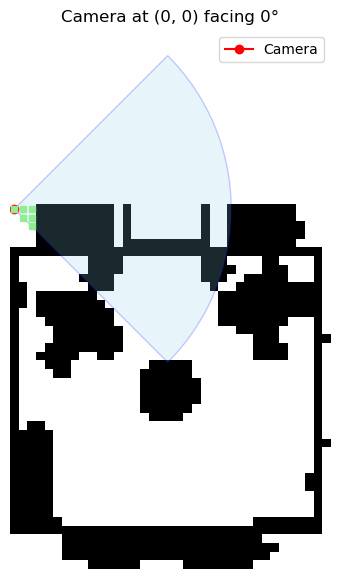

In [13]:
from matplotlib.patches import Wedge

# Visualization
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(grid, cmap='gray_r')
ax.set_title(f"Camera at ({cam_i}, {cam_j}) facing {direction}°")

# Draw cone sector (in degrees)
cone_start = (direction - CONE_ANGLE / 2) % 360
wedge = Wedge(
    center=(cam_j, cam_i),
    r=MAX_RANGE,
    theta1=cone_start,
    theta2=(cone_start + CONE_ANGLE) % 360,
    edgecolor='blue',
    facecolor='skyblue',
    alpha=0.2
)
ax.add_patch(wedge)

# Plot camera location
ax.plot(cam_j, cam_i, marker='o', color='red', label="Camera")

# Plot visible cells
for (r, c) in visible_cells:
    ax.plot(c, r, 's', color='lightgreen', markersize=4)

ax.legend()
plt.axis('off')
plt.show()


The wedge = “if there were no walls, this is what the camera could potentially see”

The green cells = “what the camera can actually see, given walls and furniture”

